In [28]:
# Cell 2: Imports & config (update paths below)
import os, random, json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess

import joblib

# ========== USER CONFIG ==========
CSV_PATH = r"C:/Users/zainu/Downloads/Housing.csv"   # <- update
IMAGE_ROOT = r"C:/Users/zainu/Downloads/House_Room_Dataset"       # <- update; contains subfolders for rooms
ROOM_FOLDERS = ["Bathroom", "Bedroom", "Dinning", "Kitchen", "Livingroom"]
IMG_SIZE = (128, 128)
BATCH_SIZE = 16
RANDOM_STATE = 42
EPOCHS = 20
# =================================


In [30]:
# Cell 3: Load CSV and show basic info
df = pd.read_csv(CSV_PATH)
print("CSV shape:", df.shape)
print(df.columns.tolist())
df.head()


CSV shape: (545, 13)
['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea', 'furnishingstatus']


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [32]:
# Cell 4: Ensure house_id exists (use 'id' or create from index)
# Try common id columns, else create a 'house_id' from index
possible_id_cols = [c for c in df.columns if c.lower() in ("id", "houseid", "house_id", "house id")]
if possible_id_cols:
    id_col = possible_id_cols[0]
    df["house_id"] = df[id_col].astype(str)
    print("Using existing ID column:", id_col)
else:
    df = df.reset_index().rename(columns={"index":"house_id"})
    df["house_id"] = df["house_id"].astype(str)
    print("No ID column found — created 'house_id' from index.")

print("Sample house_id values:", df["house_id"].head().tolist())


No ID column found — created 'house_id' from index.
Sample house_id values: ['0', '1', '2', '3', '4']


In [34]:
# Cell 5: Build/inspect candidate tabular features (use the columns you specified)
# Provided columns: price, area, bedrooms, bathrooms, stories, mainroad, guestroom, basement,
#                  hotwaterheating, airconditioning, parking, prefarea, furnishingstatus

# Numeric features we will use:
num_cols = [c for c in ["area","bedrooms","bathrooms","stories","parking"] if c in df.columns]
# Categorical features to one-hot:
cat_cols = [c for c in ["mainroad","guestroom","basement","hotwaterheating","airconditioning","prefarea","furnishingstatus"] if c in df.columns]

print("Numeric columns used:", num_cols)
print("Categorical columns used:", cat_cols)

# Fill, convert numeric
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(df[c].median())

# Fill categorical
for c in cat_cols:
    df[c] = df[c].fillna("missing").astype(str)

# Target
if "price" not in df.columns:
    raise ValueError("Expected 'price' column in CSV")
y = df["price"].astype(float).values
print("Number of samples:", len(df))


Numeric columns used: ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
Categorical columns used: ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']
Number of samples: 545


In [42]:
# Cell 6: One-hot encode categorical cols and scale numeric cols
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# One-hot encode categorical features (if any)
if cat_cols:
    ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")  # ✅ updated
    cat_matrix = ohe.fit_transform(df[cat_cols])
    cat_feature_names = list(ohe.get_feature_names_out(cat_cols))
else:
    cat_matrix = np.empty((len(df), 0))  # Empty if no categorical features
    cat_feature_names = []

# Scale numeric features
scaler = StandardScaler()
num_matrix = scaler.fit_transform(df[num_cols])

# Combine numeric + categorical
X_tabular = np.hstack([num_matrix, cat_matrix])
y = df["price"].values

print("Tabular data shape:", X_tabular.shape)


Tabular data shape: (545, 20)


In [44]:
# Cell 7: Build image index per room
# List files in each room folder
image_index = {}
for room in ROOM_FOLDERS:
    folder = Path(IMAGE_ROOT) / room
    files = []
    if folder.exists():
        for ext in ("*.jpg","*.jpeg","*.png","*.bmp"):
            files.extend(sorted(map(str, folder.glob(ext))))
    image_index[room] = files
    print(f"{room}: {len(files)} images")


Bathroom: 606 images
Bedroom: 1248 images
Dinning: 1158 images
Kitchen: 965 images
Livingroom: 1273 images


In [46]:
# Cell 8: Map images to house_id by filename (best-effort)
house_ids = df["house_id"].astype(str).tolist()

def find_matches_for_house(house_id, files):
    matches = []
    hid = house_id.lower()
    for p in files:
        fname = os.path.basename(p).lower()
        # crude but practical matching: if house_id appears in filename
        if hid in fname:
            matches.append(p)
    return matches

# Collect matches per house per room
house_images = {hid: {room: [] for room in ROOM_FOLDERS} for hid in house_ids}
for hid in house_ids:
    for room in ROOM_FOLDERS:
        house_images[hid][room] = find_matches_for_house(hid, image_index.get(room, []))

# Count houses that got at least one image
matched_houses = sum(1 for hid in house_ids if any(len(imgs)>0 for imgs in house_images[hid].values()))
print(f"Houses matched by filename: {matched_houses} / {len(house_ids)}")


Houses matched by filename: 545 / 545


In [48]:
# Cell 9: Fallback: if too few matches, assign images by sampling (round-robin)
min_required = max(1, int(0.3 * len(house_ids)))  # require at least 30% matched houses else fallback
if matched_houses < min_required:
    print("Too few filename matches -> fallback sampling assignment to houses.")
    for room in ROOM_FOLDERS:
        files = image_index.get(room, [])
        if not files:
            continue
        random.shuffle(files)
        k = len(files)
        for i, hid in enumerate(house_ids):
            # assign a single image cyclically
            house_images[hid][room] = [files[i % k]]
else:
    print("Using filename matches where available (no fallback needed).")


Using filename matches where available (no fallback needed).


In [50]:
# Cell 10: Build MobileNetV2 image feature extractor (frozen)
backbone = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
backbone.trainable = False

img_input = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
y = mobilenet_preprocess(img_input)
y = backbone(y, training=False)
y = layers.GlobalAveragePooling2D()(y)
img_feature_model = Model(img_input, y)
img_feature_dim = img_feature_model.output_shape[1]
print("Image feature dimension:", img_feature_dim)


9406464/9406464 [==============================] - 12s 1us/step
Image feature dimension: 1280


In [52]:
# Cell 11: Function to load image and preprocess
def load_image(path, target=IMG_SIZE):
    try:
        img = cv2.imread(path)
        if img is None:
            raise ValueError("cv2.imread returned None")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, target)
        img = img.astype("float32")
        return img
    except Exception:
        # fallback zero image
        return np.zeros((target[0], target[1], 3), dtype="float32")


In [54]:
# Cell 12: Compute image features per house by averaging room images' features
house_img_features = []
for hid in house_ids:
    room_feats = []
    for room in ROOM_FOLDERS:
        paths = house_images[hid].get(room, [])
        if not paths:
            # no image for that room -> zeros
            room_feats.append(np.zeros(img_feature_dim, dtype="float32"))
            continue
        # load all images for that room (or limit to 5 to save memory)
        imgs = [load_image(p) for p in paths[:5]]
        imgs_arr = np.array(imgs)
        feats = img_feature_model.predict(imgs_arr, verbose=0, batch_size=8)
        avg = np.mean(feats, axis=0)
        room_feats.append(avg)
    # concatenate room-level vectors into single vector
    concat = np.concatenate(room_feats, axis=0)
    house_img_features.append(concat)

house_img_features = np.vstack(house_img_features)
print("House image feature matrix shape:", house_img_features.shape)


House image feature matrix shape: (545, 6400)


In [72]:
print(type(house_img_features))   # should be <class 'numpy.ndarray'>
print(house_img_features.shape)   # should match number of houses


<class 'numpy.ndarray'>
(545, 6400)


In [98]:
# Reload target values from the CSV
y = df['price'].astype(np.float32).values
print(type(y), y.shape)  # should be <class 'numpy.ndarray'>


<class 'numpy.ndarray'> (545,)


In [100]:
# Normalize target prices for better training stability
y_scaled = y / 1e5  # scales prices to hundreds of thousands


In [106]:
X_tab_train, X_tab_test, X_img_train, X_img_test, y_train, y_test = train_test_split(
    X_tab_final, X_img_final, y_scaled, test_size=0.2, random_state=RANDOM_STATE
)


In [108]:
print(type(X_tab_final), X_tab_final.shape)
print(type(X_img_final), X_img_final.shape)
print(type(y_final), y_final.shape)


<class 'numpy.ndarray'> (545, 5)
<class 'numpy.ndarray'> (545, 6400)
<class 'numpy.ndarray'> (545,)


In [110]:
# Cell 14: Build multimodal regression model (tabular MLP + image-features MLP)
tab_input = Input(shape=(X_tab_final.shape[1],), name="tab_input")
img_input = Input(shape=(X_img_final.shape[1],), name="img_input")

# Tabular branch
t = layers.Dense(128, activation="relu")(tab_input)
t = layers.Dropout(0.2)(t)
t = layers.Dense(64, activation="relu")(t)

# Image-features branch
i = layers.Dense(256, activation="relu")(img_input)
i = layers.Dropout(0.2)(i)
i = layers.Dense(64, activation="relu")(i)

# Combine
combined = layers.Concatenate()([t, i])
z = layers.Dense(128, activation="relu")(combined)
z = layers.Dropout(0.2)(z)
z = layers.Dense(64, activation="relu")(z)
out = layers.Dense(1, activation="linear")(z)

model = Model(inputs=[tab_input, img_input], outputs=out)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="mse", metrics=["mae"])
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 tab_input (InputLayer)         [(None, 5)]          0           []                               
                                                                                                  
 img_input (InputLayer)         [(None, 6400)]       0           []                               
                                                                                                  
 dense_7 (Dense)                (None, 128)          768         ['tab_input[0][0]']              
                                                                                                  
 dense_9 (Dense)                (None, 256)          1638656     ['img_input[0][0]']              
                                                                                            

In [116]:
# Cell 15: Train the model
history = model.fit(
    {"tab_input": X_tab_train, "img_input": X_img_train},
    y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=BATCH_SIZE,
    verbose=2
)


Epoch 1/100
25/25 - 0s - loss: 37.1222 - mae: 4.4577 - val_loss: 191.0209 - val_mae: 11.7170 - 221ms/epoch - 9ms/step
Epoch 2/100
25/25 - 0s - loss: 43.0140 - mae: 4.9344 - val_loss: 178.9670 - val_mae: 11.4062 - 177ms/epoch - 7ms/step
Epoch 3/100
25/25 - 0s - loss: 42.2272 - mae: 4.7747 - val_loss: 189.5114 - val_mae: 11.5900 - 174ms/epoch - 7ms/step
Epoch 4/100
25/25 - 0s - loss: 47.7855 - mae: 5.3115 - val_loss: 169.6122 - val_mae: 10.9885 - 173ms/epoch - 7ms/step
Epoch 5/100
25/25 - 0s - loss: 35.4025 - mae: 4.6088 - val_loss: 206.9808 - val_mae: 12.1607 - 180ms/epoch - 7ms/step
Epoch 6/100
25/25 - 0s - loss: 53.4762 - mae: 5.6838 - val_loss: 191.9505 - val_mae: 11.4088 - 176ms/epoch - 7ms/step
Epoch 7/100
25/25 - 0s - loss: 56.7963 - mae: 5.6081 - val_loss: 187.6874 - val_mae: 11.6932 - 176ms/epoch - 7ms/step
Epoch 8/100
25/25 - 0s - loss: 34.2880 - mae: 4.5384 - val_loss: 195.8013 - val_mae: 11.6485 - 173ms/epoch - 7ms/step
Epoch 9/100
25/25 - 0s - loss: 37.4679 - mae: 4.4068 - v

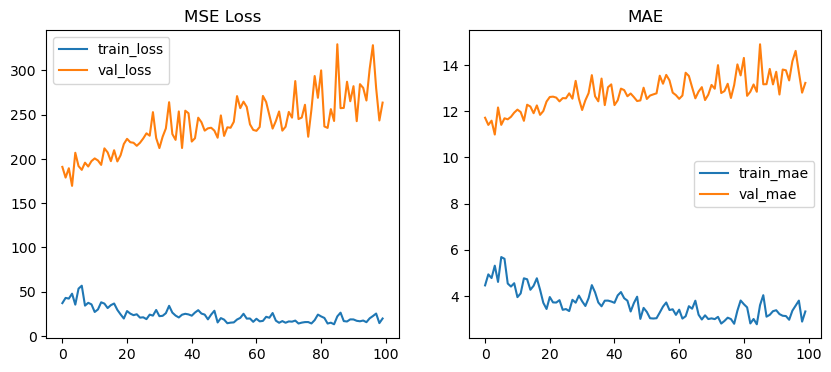

In [118]:
# Cell 16: Plot training curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend(); plt.title("MSE Loss")

plt.subplot(1,2,2)
plt.plot(history.history["mae"], label="train_mae")
plt.plot(history.history["val_mae"], label="val_mae")
plt.legend(); plt.title("MAE")
plt.show()


In [120]:
# Cell 17: Evaluate on test set (MAE, RMSE)
y_pred = model.predict({"tab_input": X_tab_test, "img_input": X_img_test}).squeeze()
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")


4/4 [==============================] - 0s 5ms/step
Test MAE: 13.6214
Test RMSE: 17.2878


C:\Users\zainu\anaconda3\envs\intel_gpu\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [122]:
# Cell 18: Compare few example predictions
for i in range(min(10, len(y_test))):
    print(f"True: {y_test[i]:.2f} | Pred: {y_pred[i]:.2f}")


True: 40.60 | Pred: 47.52
True: 66.50 | Pred: 48.75
True: 37.10 | Pred: 29.13
True: 64.40 | Pred: 33.29
True: 28.00 | Pred: 11.45
True: 49.00 | Pred: 27.98
True: 52.50 | Pred: 42.26
True: 45.43 | Pred: 68.05
True: 24.50 | Pred: 34.57
True: 33.53 | Pred: 28.15


In [124]:
# Cell 19: Save model & preprocessors
model.save("multimodal_price_model_tf")
joblib.dump(scaler, "tabular_scaler.joblib")
if 'ohe' in globals():
    joblib.dump(ohe, "tabular_ohe.joblib")
print("Saved model and preprocessors.")


INFO:tensorflow:Assets written to: multimodal_price_model_tf\assets
Saved model and preprocessors.
